# GANs - GENERATIVE ADVERSARIAL NETWORKS

Brief introduction to Generative Adversarial Networks or GANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training GANs with MNIST dataset, Keras and TensorFlow**
* **Tips and tricks**

## 1. Research Paper

* [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)

## 2. Background

Brief definition of some concepts, such as supervised and unsupervised learning, and discriminative and generative models.

### Supervised learning

Supervised learning algorithms learn to map a function $\hat{y}=f(x)$, given labeled data y.

* Examples: Classification algorithms (SVM), regression algorithms (Linear regression).

* Applications: Object detection, semantic segmentation, image captioning, etc.

### Unsupervised learning

Unsupervised learning algorithms learn the underlying structure of the given data, without specifying a target value.

* Examples: Clustering algorithms (k-means), generative models (GANs)

* Applications: Dimensionality reduction, feature learning, density estimation, etc.

### Discriminative models

Most of the supervised learning algorithms are inherently discriminative. 

Discriminative model allows us to evaluate the **conditional probability** $P(y|x)$.

Learns a function that maps the input $x$ to an output $y$.

* Examples: Logistic regression, Support Vector Machines, Neural networks.

### Generative models

Most of the unsupervised learning algorithms are inherently generative.

Generative model can allows us to evaluate the **joint probability** $P(x,y)$.

Tries to learn a joint probability of the input $x$ and the output $y$ at the same time.

* Examples: Latent Dirichlet allocation, Restricted Boltzmann machine, Generative adversarial networks.


## 3. Definition

Generative Adversarial Networks or GANs is a framework proposed by [Ian Goodfellow](http://www.iangoodfellow.com/), Yoshua Bengio and others in 2014.

GANs are composed of two models, represented by neural networks:
* The first model is called a **Generator** and it aims to generate new data similar to the expected one. 
* The second model is named the **Discriminator** and it aims to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger.


* **Generator Network**: The input to the generator is a series of randomly generated numbers called **latent sample**. It tries to produce data that come from some probability distribution. The generator network takes random noise as input, then runs that noise through a differentiable function to transform the noise and reshape it to have recognizable structure. The output of the generator network ia a realistic image. Without training, the generator produces garbage images only. 
    
    So z (latent sample, vector of unstructured noise) is essentially a vector of unstructured noise. It’s a source of randomness that allows the generator to output a wide variety of different vectors.


* **Discriminator Network**: The discriminator is a **classifier** trained using the **supervised learning**. It classifies whether an image is real (1) or is fake (0).


* **Training GANs: Two player game**: The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

    $G$ try to fool discriminator by generating real-looking images.

    $D$ try to distinguish between real and fake images.

    Train jointly in **minimax game**
    
### Network Design

<p align="center">
    <img src="../../img/network_design_gan.png" width="600"\>
</p>

### Cost function

Minimax objective function (Value Function or Cost Function of Minimax Game played by Generator and Discriminator):

$$ \underset{\theta_{g}}{min} \: \underset{\theta_{d}}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D_{\theta_{d}}(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

* $D_{\theta_{d}}$ wants to maximize  objective such that $D(x)$ is close to 1 (real) and $D(G(z))$ is close to 0 (fake).
* $G_{\theta_{g}}$ wants to minimize objective such that $D(G(z))$ is close to 1 (discriminator is fooled into thinking generated G(z) is real).

Alternate between:
1. Gradient ascent on D
$$\underset{\theta_{d}}{max} [\mathbb{E}_{x\sim p_{data}(x)}log D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)}log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

2. Instead: Gradient ascent on generator, different objective
$$\underset{\theta_{g}}{max}[\mathbb{E}_{z\sim p_{z}(z)}[log( D_{\theta_{d}}(G_{\theta_{g}}(z)))] $$

Instead of minimizing likelihood of discriminator being correct, now maximize likelihood of discriminator being wrong. Same objetive of fooling discriminator, but now higher gradient signal for bad samples => works much better!

As a result, 
* the Discriminator is trained to correctly classify the input data as either real or fake. 
    * This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. 
    * In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).
* the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes D(G(z)).

## 3. Training GANs with MNIST dataset, Keras and TensorFlow

A standard GANs implementations using fully connected layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image.  We use the **normal distribution**.
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#### Explore visual data

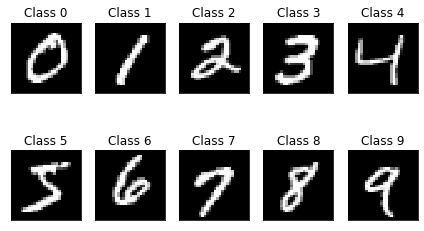

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)

# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

#### Discriminator

In [8]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Combined network

In [11]:
discriminator.trainable = False

d_g = Sequential()
d_g.add(generator)
d_g.add(discriminator)
d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [12]:
# prints a summary representation of your model
d_g.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 784)               583312    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 265601    
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


### 4. Fit model

epoch = 1/100, d_loss=0.551, g_loss=1.645                                                                                                     


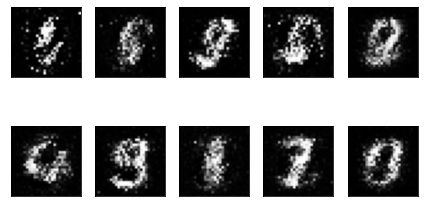

epoch = 2/100, d_loss=0.624, g_loss=1.787                                                                                                     
epoch = 3/100, d_loss=0.605, g_loss=1.457                                                                                                     
epoch = 4/100, d_loss=0.567, g_loss=1.351                                                                                                     
epoch = 5/100, d_loss=0.578, g_loss=1.187                                                                                                     
epoch = 6/100, d_loss=0.617, g_loss=1.201                                                                                                     
epoch = 7/100, d_loss=0.599, g_loss=1.122                                                                                                     
epoch = 8/100, d_loss=0.616, g_loss=1.129                                                                                                     

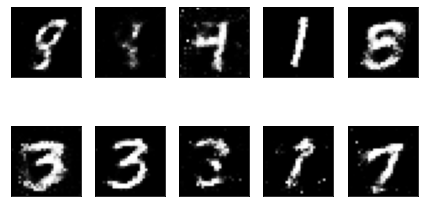

epoch = 12/100, d_loss=0.569, g_loss=1.035                                                                                                     
epoch = 13/100, d_loss=0.637, g_loss=0.993                                                                                                     
epoch = 14/100, d_loss=0.627, g_loss=1.043                                                                                                     
epoch = 15/100, d_loss=0.596, g_loss=1.087                                                                                                     
epoch = 16/100, d_loss=0.655, g_loss=1.033                                                                                                     
epoch = 17/100, d_loss=0.652, g_loss=1.027                                                                                                     
epoch = 18/100, d_loss=0.633, g_loss=1.012                                                                                              

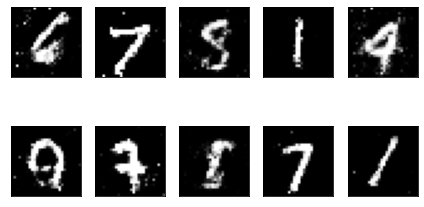

epoch = 22/100, d_loss=0.594, g_loss=1.045                                                                                                     
epoch = 23/100, d_loss=0.631, g_loss=1.094                                                                                                     
epoch = 24/100, d_loss=0.662, g_loss=1.021                                                                                                     
epoch = 25/100, d_loss=0.637, g_loss=1.099                                                                                                     
epoch = 26/100, d_loss=0.652, g_loss=1.129                                                                                                     
epoch = 27/100, d_loss=0.633, g_loss=1.189                                                                                                     
epoch = 28/100, d_loss=0.625, g_loss=1.175                                                                                              

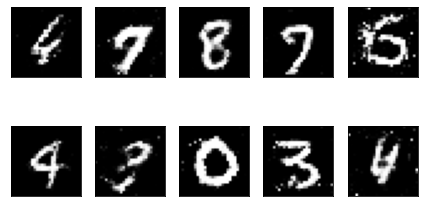

epoch = 32/100, d_loss=0.669, g_loss=1.130                                                                                                     
epoch = 33/100, d_loss=0.571, g_loss=1.151                                                                                                     
epoch = 34/100, d_loss=0.535, g_loss=1.229                                                                                                     
epoch = 35/100, d_loss=0.566, g_loss=1.123                                                                                                     
epoch = 36/100, d_loss=0.600, g_loss=1.147                                                                                                     
epoch = 37/100, d_loss=0.573, g_loss=1.209                                                                                                     
epoch = 38/100, d_loss=0.590, g_loss=1.177                                                                                              

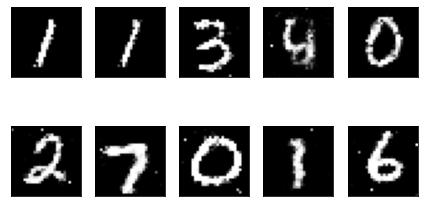

epoch = 42/100, d_loss=0.590, g_loss=1.155                                                                                                     
epoch = 43/100, d_loss=0.610, g_loss=1.252                                                                                                     
epoch = 44/100, d_loss=0.549, g_loss=1.322                                                                                                     
epoch = 45/100, d_loss=0.536, g_loss=1.260                                                                                                     
epoch = 46/100, d_loss=0.569, g_loss=1.269                                                                                                     
epoch = 47/100, d_loss=0.582, g_loss=1.104                                                                                                     
epoch = 48/100, d_loss=0.571, g_loss=1.118                                                                                              

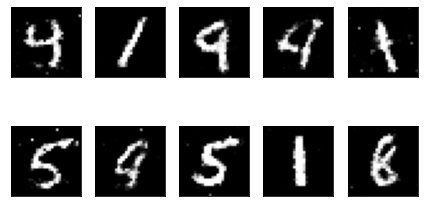

epoch = 52/100, d_loss=0.564, g_loss=1.324                                                                                                     
epoch = 53/100, d_loss=0.542, g_loss=1.347                                                                                                     
epoch = 54/100, d_loss=0.590, g_loss=1.281                                                                                                     
epoch = 55/100, d_loss=0.573, g_loss=1.349                                                                                                     
epoch = 56/100, d_loss=0.540, g_loss=1.376                                                                                                     
epoch = 57/100, d_loss=0.537, g_loss=1.270                                                                                                     
epoch = 58/100, d_loss=0.538, g_loss=1.342                                                                                              

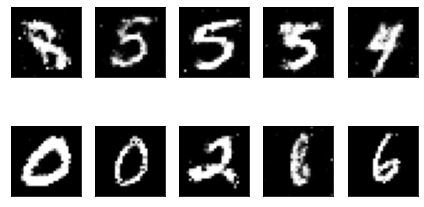

epoch = 62/100, d_loss=0.564, g_loss=1.245                                                                                                     
epoch = 63/100, d_loss=0.526, g_loss=1.291                                                                                                     
epoch = 64/100, d_loss=0.480, g_loss=1.445                                                                                                     
epoch = 65/100, d_loss=0.561, g_loss=1.327                                                                                                     
epoch = 66/100, d_loss=0.552, g_loss=1.299                                                                                                     
epoch = 67/100, d_loss=0.498, g_loss=1.373                                                                                                     
epoch = 68/100, d_loss=0.473, g_loss=1.450                                                                                              

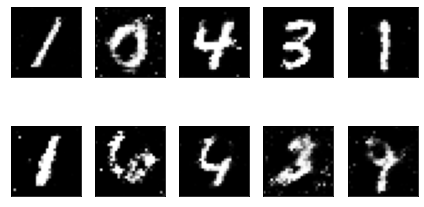

epoch = 72/100, d_loss=0.470, g_loss=1.562                                                                                                     
epoch = 73/100, d_loss=0.530, g_loss=1.384                                                                                                     
epoch = 74/100, d_loss=0.495, g_loss=1.441                                                                                                     
epoch = 75/100, d_loss=0.529, g_loss=1.336                                                                                                     
epoch = 76/100, d_loss=0.502, g_loss=1.429                                                                                                     
epoch = 77/100, d_loss=0.579, g_loss=1.343                                                                                                     
epoch = 78/100, d_loss=0.506, g_loss=1.385                                                                                              

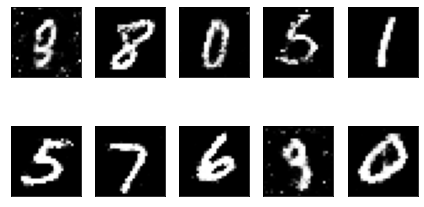

epoch = 82/100, d_loss=0.515, g_loss=1.502                                                                                                     
epoch = 83/100, d_loss=0.500, g_loss=1.395                                                                                                     
epoch = 84/100, d_loss=0.537, g_loss=1.471                                                                                                     
epoch = 85/100, d_loss=0.553, g_loss=1.500                                                                                                     
epoch = 86/100, d_loss=0.462, g_loss=1.463                                                                                                     
epoch = 87/100, d_loss=0.480, g_loss=1.439                                                                                                     
epoch = 88/100, d_loss=0.496, g_loss=1.393                                                                                              

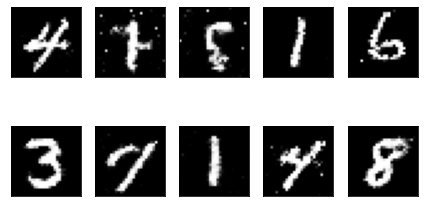

epoch = 92/100, d_loss=0.511, g_loss=1.544                                                                                                     
epoch = 93/100, d_loss=0.470, g_loss=1.500                                                                                                     
epoch = 94/100, d_loss=0.514, g_loss=1.550                                                                                                     
epoch = 95/100, d_loss=0.534, g_loss=1.459                                                                                                     
epoch = 96/100, d_loss=0.500, g_loss=1.697                                                                                                     
epoch = 97/100, d_loss=0.520, g_loss=1.542                                                                                                     
epoch = 98/100, d_loss=0.492, g_loss=1.427                                                                                              

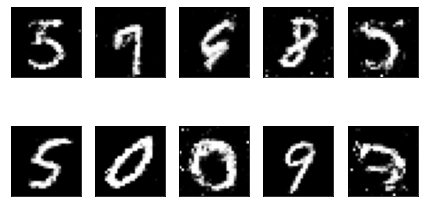

In [13]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(
            np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        )

        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

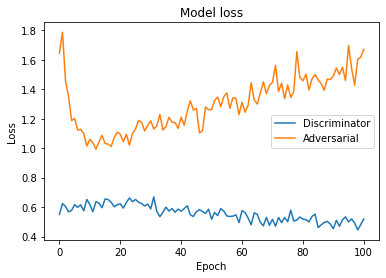

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## 5. Tips and tricks

### Training GANS

We train the discriminator and the generator in turn in a loop as follows:

1. Set the discriminator trainable
2. Train the discriminator with the real digit images and the images generated by the generator to classify the real and fake images.
3. Set the discriminator non-trainable
4. Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image.

---
1. Decide on the GAN architecture: What is architecture of G? What is the architecture of D?
1. Train: Alternately update D and G for a fixed number of updates
    * Update D (freeze G): Half the samples are real, and half are fake.
    * Update G (freeze D): All samples are generated (note that even though D is frozen, the gradients flow through D)
1. Manually inspect some fake samples. If quality is high enough (or if quality is not improving), then stop. Else repeat step 2.

### Practical tips and tricks for training

It’s important to choose a good overall architecture. For this architecture:
* That both the generator and the discriminator have at least one hidden layer.
* Two simultaneous optimizations. 
* We define a loss for the G and D. Minimize the loss for the D, while simultaneously use another optimizer to minimize the loss for the G. 
* Overall this recipe of using batch normalization, Adam optimization and Cross entropy losses with label smoothing works fairly well in practice. 

### Applications 

GANs have already become widely known for their application versatility and their outstanding results in generating data. They have been used in real-life applications for:
* Text generation, 
* Image generation,
* Video generation, and 
* Text-to-image synthesis.

### Pros

* Game-theoretic approach,
* Generate the sharpest images,
* Easy to train (since no statistical inference is required), and only back-propogation is needed to obtain gradients.

### Cons

* Can be tricky and unstable to train, no inference queries. No statistical inference can be done with them. (They belong to the class of direct implicit density models (they can model p(x) without explicitly defining the p.d.f)).
* Difficult to optimize due to unstable training dynamics.

### Conclusion

The generator must ask for suggestions from the discriminator and intuitively, the discriminator tells how much to tweak each pixel in order to make the image a little bit more realistic.
